In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt

In [129]:
df = pd.read_csv('uspto_gram_t.csv')




In [130]:
min_yield = df['yield'].min()
max_yield = df['yield'].max()

# Apply the normalization formula
df['normalized_yield'] = (df['yield'] - min_yield) / (max_yield - min_yield)

# Check the first few rows to verify the normalization
print(df[['yield', 'normalized_yield']].head())

       yield  normalized_yield
0  83.065588          0.832693
1  80.075804          0.763223
2  73.606949          0.612912
3  72.065263          0.577090
4  72.226152          0.580828


In [131]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [132]:
label_encoder = LabelEncoder()

# # Fit and transform the feature
# df_shuffled['encoded_rxn'] = label_encoder.fit_transform(df_shuffled['canonical_rxn'])

In [133]:
import numpy as np

 # Get the number of unique reactions
unique_reactions = df_shuffled['canonical_rxn'].unique()

# Generate a random list of unique numbers, ensuring no duplicates
random_numbers = np.random.permutation(len(unique_reactions))

# Create a mapping dictionary from reactions to random numbers
random_mapping = dict(zip(unique_reactions, random_numbers))

# Map the reactions to their respective random numbers
df_shuffled['encoded_rxn'] = df_shuffled['canonical_rxn'].map(random_mapping)
# Verify that the encoded_rxn column has unique random numbers
print(df_shuffled[['canonical_rxn', 'encoded_rxn']].head())

                                       canonical_rxn  encoded_rxn
0  CI.COc1cccc2nc(C(F)(F)F)[nH]c12>>COc1cccc2c1nc...        29833
1  CC(C)(C)OC(=O)[C@H](NC(=O)NC1CCCC1)c1ccccc1>>O...        14557
2     CC(C)(C)OC(=O)Nc1ccncc1C(=O)O>>Nc1ccncc1C(=O)O        57517
3  CC(C)N(c1nnc2ccc(F)cn12)C(C)C.N[C@H]1CC[C@@H](...        49294
4  COC(=O)c1ccccc1C=O.N#CC=P(c1ccccc1)(c1ccccc1)c...        45460


In [134]:
X_temp = df_shuffled[['temperature']]
X_reaction = df_shuffled[['encoded_rxn']]
X_temp_reaction = pd.concat([df_shuffled[['temperature']], df_shuffled[['encoded_rxn']]], axis=1)


In [135]:
y = df_shuffled['normalized_yield']

In [136]:
X_temp_train, X_temp_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42)
X_reaction_train, X_reaction_test, _, _ = train_test_split(X_reaction, y, test_size=0.2, random_state=42)
X_temp_reaction_train, X_temp_reaction_test, _, _ = train_test_split(X_temp_reaction, y, test_size=0.2, random_state=42)

In [137]:
import pandas as pd

# Assuming X_train and X_test are pandas DataFrames
# Check for duplicates within each dataset
duplicates_in_X_train = X_reaction_train.duplicated().sum()
duplicates_in_X_test = X_reaction_test.duplicated().sum()

print(f"Number of duplicate rows in X_reaction_train: {duplicates_in_X_train}")
print(f"Number of duplicate rows in X_reaction_test: {duplicates_in_X_test}")

# Check for any rows in X_train that also exist in X_test
df34 = pd.concat([X_reaction_train, X_reaction_test])
duplicates_between_sets = pd.concat([X_reaction_train, X_reaction_test]).duplicated().sum() - duplicates_in_X_train - duplicates_in_X_test
per = duplicates_between_sets / len(df34) * 100
print(f"Number of common duplicate rows between X_reaction_train and X_reaction_test: {duplicates_between_sets}")
print(f"Percentage of duplicates : {per} ")

Number of duplicate rows in X_reaction_train: 26290
Number of duplicate rows in X_reaction_test: 3263
Number of common duplicate rows between X_reaction_train and X_reaction_test: 6441
Percentage of duplicates : 6.78064237664621 


In [138]:
model_temp = LinearRegression()
model_reaction = LinearRegression()
model_temp_reaction = LinearRegression()

In [139]:
rf_model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reaction = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_temp_reaction = RandomForestRegressor(n_estimators=100, random_state=42)

In [140]:
X_reaction_train.shape

(75992, 1)

In [141]:
y_train.shape

(75992,)

In [142]:
model_temp.fit(X_temp_train, y_train)
model_reaction.fit(X_reaction_train, y_train)
model_temp_reaction.fit(X_temp_reaction_train, y_train)



LinearRegression()

In [143]:
rf_model_temp.fit(X_temp_train, y_train)
rf_model_reaction.fit(X_reaction_train, y_train)
rf_model_temp_reaction.fit(X_temp_reaction_train, y_train)

RandomForestRegressor(random_state=42)

In [144]:
y_pred_temp = model_temp.predict(X_temp_test)
y_pred_reaction = model_reaction.predict(X_reaction_test)
y_pred_temp_reaction = model_temp_reaction.predict(X_temp_reaction_test)

In [145]:
rf_y_pred_temp = rf_model_temp.predict(X_temp_test)
rf_y_pred_reaction = rf_model_reaction.predict(X_reaction_test)
rf_y_pred_temp_reaction = rf_model_temp_reaction.predict(X_temp_reaction_test)

In [146]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the original reaction-only model
cv_scores = cross_val_score(rf_model_reaction, X_reaction_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE to positive
cv_scores = -cv_scores
mean_cv_score = np.mean(cv_scores)

print(f"Cross-Validated MSE for Reaction-Only RF Model: {mean_cv_score:.4f}")


Cross-Validated MSE for Reaction-Only RF Model: 0.0154


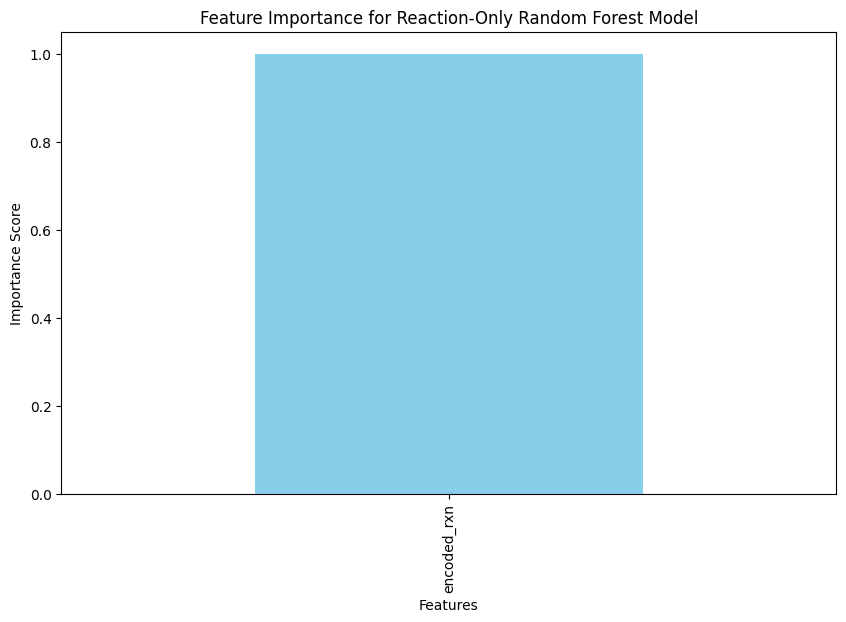

In [147]:
feature_importance = pd.Series(rf_model_reaction.feature_importances_, index=X_reaction_train.columns)

# Plot the feature importance
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Feature Importance for Reaction-Only Random Forest Model')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

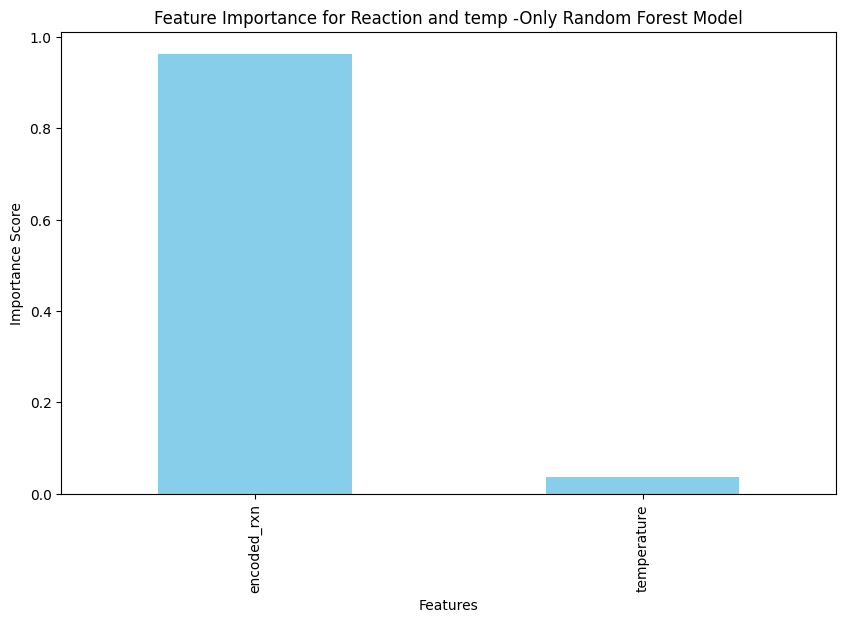

In [148]:
feature_importance = pd.Series(rf_model_temp_reaction.feature_importances_, index=X_temp_reaction_train.columns)

# Plot the feature importance
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Feature Importance for Reaction and temp -Only Random Forest Model')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

In [149]:
r2_reaction = r2_score(y_test, y_pred_reaction)
mse_reaction = mean_squared_error(y_test, y_pred_reaction)
mae_reaction = mean_absolute_error(y_test, y_pred_reaction)
mse_temp = mean_squared_error(y_test, y_pred_temp)
r2_temp = r2_score(y_test, y_pred_temp)
mae_temp = mean_absolute_error(y_test, y_pred_temp)

mse_temp_reaction = mean_squared_error(y_test, y_pred_temp_reaction)
r2_temp_reaction = r2_score(y_test, y_pred_temp_reaction)
mae_temp_reaction = mean_absolute_error(y_test, y_pred_temp_reaction)

In [150]:
rf_r2_reaction = r2_score(y_test, rf_y_pred_reaction)
rf_mse_reaction = mean_squared_error(y_test, rf_y_pred_reaction)
rf_mae_reaction = mean_absolute_error(y_test, rf_y_pred_reaction)
rf_mse_temp = mean_squared_error(y_test, rf_y_pred_temp)
rf_r2_temp = r2_score(y_test, rf_y_pred_temp)
rf_mae_temp = mean_absolute_error(y_test, rf_y_pred_temp)

rf_mse_temp_reaction = mean_squared_error(y_test, rf_y_pred_temp_reaction)
rf_r2_temp_reaction = r2_score(y_test, rf_y_pred_temp_reaction)
rf_mae_temp_reaction = mean_absolute_error(y_test, rf_y_pred_temp_reaction)

In [151]:
print(f"Temperature Only Model - MSE: {mse_temp:.4f}, MAE: {mae_temp:.4f}, R^2: {r2_temp:.4f}")
print(f"Reaction Only Model - MSE: {mse_reaction:.4f}, MAE: {mae_reaction:.4f}, R^2: {r2_reaction:.4f}")
print(f"Temperature and Reaction Model - MSE: {mse_temp_reaction:.4f}, MAE: {mae_temp_reaction:.4f}, R^2: {r2_temp_reaction:.4f}")

Temperature Only Model - MSE: 0.0183, MAE: 0.1063, R^2: 0.0014
Reaction Only Model - MSE: 0.0183, MAE: 0.1064, R^2: 0.0000
Temperature and Reaction Model - MSE: 0.0183, MAE: 0.1063, R^2: 0.0015


In [152]:
print(f"Temperature Only  RF Model - MSE: {rf_mse_temp:.4f}, MAE: {rf_mae_temp:.4f}, R^2: {rf_r2_temp:.4f}")
print(f"Reaction Only RF Model - MSE: {rf_mse_reaction:.4f}, MAE: {rf_mae_reaction:.4f}, R^2: {rf_r2_reaction:.4f}")
print(f"Temperature and Reaction RF Model - MSE: {rf_mse_temp_reaction:.4f}, MAE: {rf_mae_temp_reaction:.4f}, R^2: {rf_r2_temp_reaction:.4f}")

Temperature Only  RF Model - MSE: 0.0182, MAE: 0.1060, R^2: 0.0063
Reaction Only RF Model - MSE: 0.0147, MAE: 0.0771, R^2: 0.1950
Temperature and Reaction RF Model - MSE: 0.0147, MAE: 0.0778, R^2: 0.1967


In [153]:
data = {
    'actual_yield': y_test,  # actual yield values
    'temp_pred':y_pred_temp ,
    'reaction_pred': y_pred_reaction
}


df1 = pd.DataFrame(data)

In [154]:
data = {
    'actual_yield': y_test,  # actual yield values
    'temp_pred':rf_y_pred_temp ,
    'reaction_pred': rf_y_pred_reaction
}


df2 = pd.DataFrame(data)

In [155]:
df1['temp_residuals'] = df1['actual_yield'] - df1['temp_pred']
df1['reaction_residuals'] = df1['actual_yield'] - df1['reaction_pred']

In [156]:
df2['temp_residuals'] = df2['actual_yield'] - df2['temp_pred']
df2['reaction_residuals'] = df2['actual_yield'] - df2['reaction_pred']

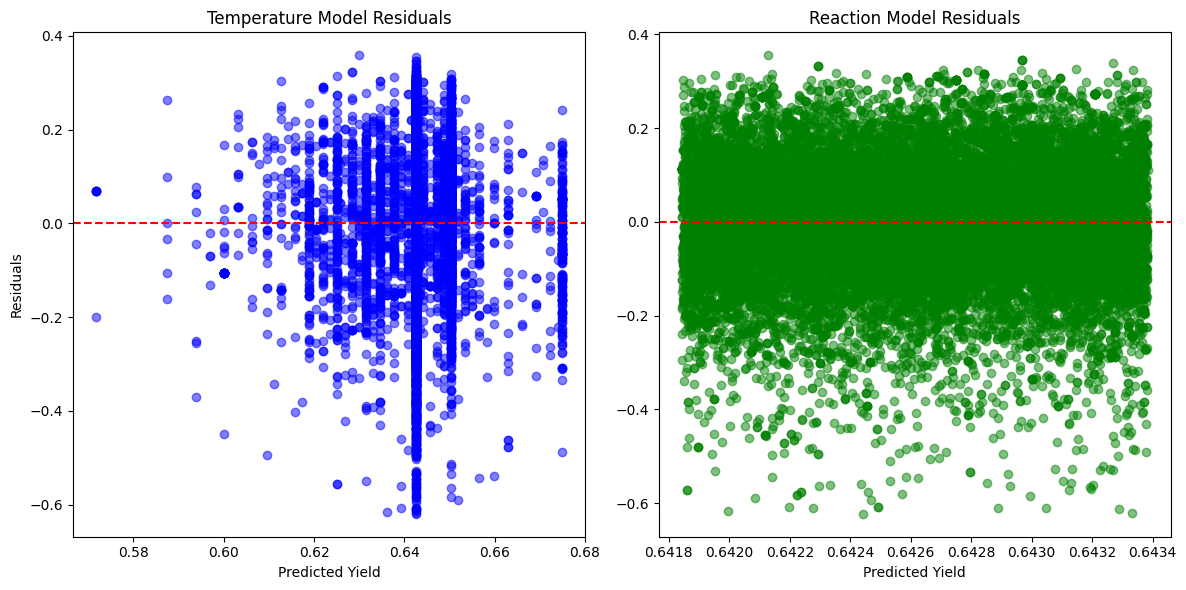

Temperature Model Predictions - Mean: 0.6426086265099724 Variance: 4.354498155065533e-05
Reaction Model Predictions - Mean: 0.6426086104258529 Variance: 1.9997525894120077e-07


In [157]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df1['temp_pred'], df1['temp_residuals'], color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Temperature Model Residuals')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(df1['reaction_pred'], df1['reaction_residuals'], color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Reaction Model Residuals')
plt.xlabel('Predicted Yield')

plt.tight_layout()
plt.show()

# Check variance and mean of predictions
print("Temperature Model Predictions - Mean:", df1['temp_pred'].mean(), "Variance:", df1['temp_pred'].var())
print("Reaction Model Predictions - Mean:", df1['reaction_pred'].mean(), "Variance:", df1['reaction_pred'].var())

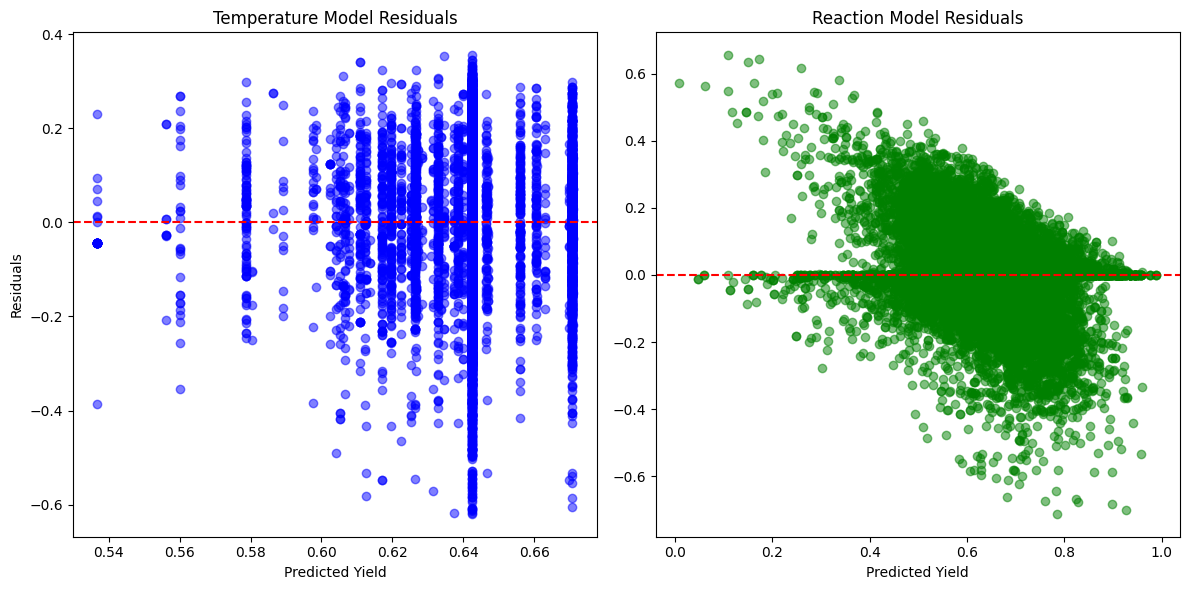

Temperature Model Predictions - Mean: 0.6424712815163706 Variance: 0.00016127850807770686
Reaction Model Predictions - Mean: 0.6421542089840752 Variance: 0.01253891037642418


In [158]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df2['temp_pred'], df2['temp_residuals'], color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Temperature Model Residuals')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(df2['reaction_pred'], df2['reaction_residuals'], color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Reaction Model Residuals')
plt.xlabel('Predicted Yield')

plt.tight_layout()
plt.show()

# Check variance and mean of predictions
print("Temperature Model Predictions - Mean:", df2['temp_pred'].mean(), "Variance:", df2['temp_pred'].var())
print("Reaction Model Predictions - Mean:", df2['reaction_pred'].mean(), "Variance:", df2['reaction_pred'].var())

In [159]:
print(df['normalized_yield'].describe())

count    94991.000000
mean         0.642548
std          0.136015
min          0.000000
25%          0.558256
50%          0.647895
75%          0.736527
max          1.000000
Name: normalized_yield, dtype: float64


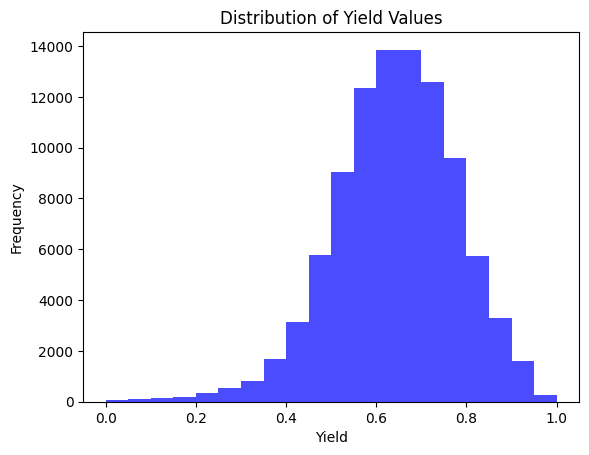

In [160]:
plt.hist(df['normalized_yield'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Yield Values')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.show()

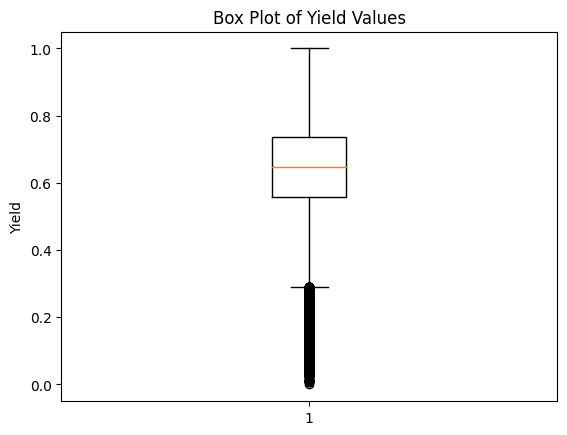

In [161]:
plt.boxplot(df['normalized_yield'])
plt.title('Box Plot of Yield Values')
plt.ylabel('Yield')
plt.show()

In [162]:
mean_yield = df['normalized_yield'].mean()
std_dev = df['normalized_yield'].std()
variance = df['normalized_yield'].var()

print(f"Mean Yield: {mean_yield}")
print(f"Standard Deviation: {std_dev}")
print(f"Variance: {variance}")

Mean Yield: 0.6425481038652678
Standard Deviation: 0.13601485036788694
Variance: 0.01850003952059867


In [163]:
skewness = df['normalized_yield'].skew()
kurtosis = df['normalized_yield'].kurt()

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

Skewness: -0.4792382158557217
Kurtosis: 0.8042363092265319


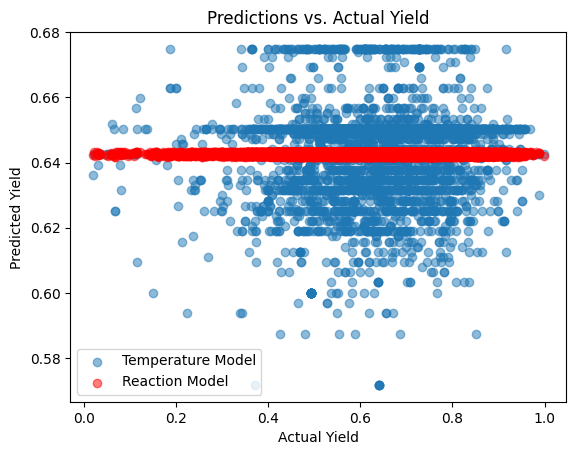

In [164]:
plt.scatter(y_test, y_pred_temp, alpha=0.5, label='Temperature Model')
plt.scatter(y_test, y_pred_reaction, alpha=0.5, color='red', label='Reaction Model')
plt.title('Predictions vs. Actual Yield')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.legend()
plt.show()

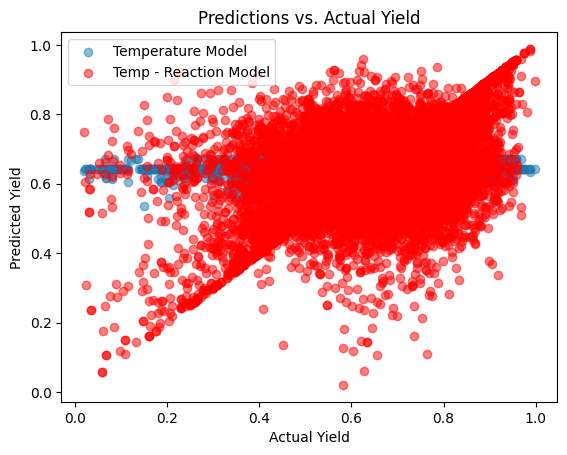

In [165]:
plt.scatter(y_test, rf_y_pred_temp, alpha=0.5, label='Temperature Model')
plt.scatter(y_test, rf_y_pred_temp_reaction, alpha=0.5, color='red', label='Temp - Reaction Model')
plt.title('Predictions vs. Actual Yield')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.legend()
plt.show()